In [8]:
#!pip install gym

In [2]:
from maze import *
from evaluation import *
from evaluation_cts import *
from evaluation_cts_mountaincar import *
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

%reload_ext autoreload
%autoreload 2


In [8]:
#1. Policy Iteration/Value Iteration

#initialize maze, V, Q, delta, gamma, policy
env = Maze()
V = np.zeros(112)
Q = np.zeros((112,4))
g = 0.9
P = np.zeros(112)
env.slip = 0 #to make deterministic
loop_flag = 1

while (loop_flag):
    D = 0
    for s in range(0,112): #iterate through all states
        v = V[s] #update v
        for a in range(0,4): #iterate through all actions
            r, s_prime, done = env.step(s,a)
            r_slip, s_prime_slip, done_slip = env.step(s,ACTMAP[a]) #0-->3, 1-->2, 2-->0, 3-->1 for slips
            Q[s,a]= (0.9*(r+(g*V[s_prime]))) + (0.1*(r_slip+(g*V[s_prime_slip]))) #update Q
            #Q[s,a]= (0.9*(r+(g*max(Q[s_prime,:])))) + (0.1*(r_slip+(g*max(Q[s_prime_slip,:])))) #equivalent Q update
        V[s] = max(Q[s,:]) #update V
        if s >= 96 and s <= 103:
            V[s] = 0 #fix bug where robot collects reward from going to goal, then goes back and collects more flags and then returns to goal - game is over and no more rewards once termination state is reached
        P[s] = np.argmax(Q[s,:]) #update policy
        D = max(D,abs(v-V[s])) #update delta
    if (D < 0.00001): #stop iterating if converged
        loop_flag = 0
        
#save Q to numpy file
np.save('1_Q',Q)
 
# for s in range(0,112):
#     for a in range(0,4):
#         print(Q[s,a])
        
        
#simulate optimized policy
print("SIMULATED OPTIMIZED POLICY: ")
state = env.reset()
done = 0
total_reward = 0
while (done==0):
    action = int(P[state])
    reward, next_state, done = env.step(state,action)
    env.plot(state,action)
    state = next_state
    total_reward = total_reward + reward
print("total flags caught: ", total_reward)



SIMULATED OPTIMIZED POLICY: 
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
total flags caught:  2.0


SIMULATED POLICY: 
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  DOWN
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
action:  RIGHT
SWFWG
OOOOO
WOOOW
FOWFW
action:  UP
SWFWG
OOOOO
WOOOW
FOWFW
total flags caught:  2.0


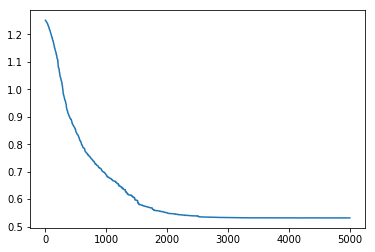

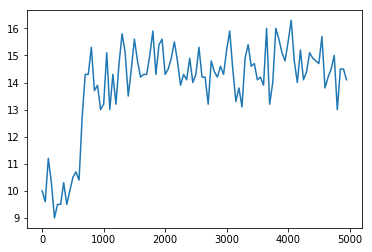

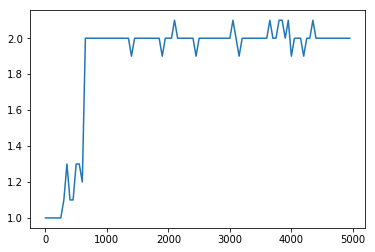

In [15]:
#2. Q-learning

# Some initialization #
eval_steps, eval_reward, rmses = [], [], []

#following algorithm from RL book pg 131
env = Maze()
P = np.zeros(112)
Q = np.zeros((112,4))
g = 0.9
e = 0.95
alpha = 0.05
Q_star = np.load('1_Q.npy')

for i in range(0,5000):#loop for each episode
    s = env.reset() #initialize S
    done = 0
    while (done==0):
        if np.random.rand() < e: #perform randomly selected action
            a = np.random.choice(4,)
        else: #perform greedy action
            a = np.argmax(Q[s,:]) #choose action from state using policy derived from Q
        r, s_prime, done = env.step(s,a) #take action a
        Q[s,a] = Q[s,a] + (alpha*(r + (g*max(Q[s_prime,:])) - Q[s,a])) #update Q* estimate using Bellman
        s = s_prime
    rms = sqrt(mean_squared_error(Q_star, Q))
    rmses.append(rms)
    if np.mod(i+1,50) == 0: #every 50 steps evaluate
        avg_step, avg_reward = evaluation(Maze(), Q)
        eval_steps.append(avg_step)
        eval_reward.append(avg_reward)
        
f1, ax1 = plt.subplots()
ax1.plot(np.arange(0,5000),rmses)
# Plot example #
f2, ax2 = plt.subplots()
ax2.plot(np.arange(0,5000,50),eval_steps)#repeat for different algs.
f3, ax3 = plt.subplots()
ax3.plot(np.arange(0,5000,50),eval_reward)#repeat for different algs.

# for s in range(0,112):
#     for a in range(0,4):
#         print(Q[s,a])


for s in range(0,112):
    P[s] = np.argmax(Q[s,:]) #update policy
    
print("SIMULATED POLICY: ")
state = env.reset()
done = 0
total_reward = 0
while (done==0):
    action = int(P[state])
    reward, next_state, done = env.step(state,action)
    env.plot(state,action)
    state = next_state
    total_reward = total_reward + reward
print("total flags caught: ", total_reward)

In [3]:
#3. Continuous State Space Problems

#acrobot

#REINCORCE following algorithm from RL book pg 330
env = gym.make('Acrobot-v1')
discount = 0.99
alpha = 0.00008
actions = [0, 1, 2]
theta = np.zeros((6,3)) #state vector x num actions

def policy(s,theta): #from https://medium.com/samkirkiles/reinforce-policy-gradients-from-scratch-in-numpy-6a09ae0dfe12
    z = s.dot(theta)
    exp = np.exp(z)
    return exp/np.sum(exp)

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

for i in range(0,100): #loop more times to get better policy
    done = 0
    s = env.reset()[None,:]
    rewards = []
    grads = []
    v = -1 #moving average of total rewards, baseline
    t = 0
    while (not done): #generate an episode
        t = t+1
        probs = policy(s,theta)
        if i >= 95:
            env.render() #see last few iterations of learning
        a = np.random.choice(actions,p=probs[0])
        result = env.step(a)
        next_s = result[0][None,:]
        reward = result[1]
        rewards.append(reward)
        done = result[2]
            
        #compute gradient
        dsoftmax = softmax_grad(probs)[a,:]
        dlog = dsoftmax / probs[0,a]
        grad = s.T.dot(dlog[None,:])
        grads.append(grad)
        
        s = next_s
    for j in range(0,len(grads)):
        G = 0
        for k in range(j+1,len(grads)):
            G = G + ((discount**(k-j-1))*rewards[k])
        delta = G-v
        v = sum(rewards[0:j])/(j+1)
        theta = theta + (alpha * (discount**j) * delta * grads[j])
    if i >= 95:
        print("Episode finished after {} timesteps".format(t))
        print(theta)
env.close()
np.save('theta',theta)

Episode finished after 154 timesteps
[[ 0.29243361 -0.18303478 -0.10939883]
 [-0.03793515 -0.02170386  0.05963901]
 [ 0.26660105 -0.22999698 -0.03660407]
 [-0.01576366  0.05366801 -0.03790435]
 [ 0.23425743 -0.06774857 -0.16650886]
 [-0.2563173   0.01385686  0.24246045]]
Episode finished after 105 timesteps
[[ 0.28808639 -0.16659316 -0.12149323]
 [-0.04070365 -0.03013838  0.07084203]
 [ 0.26425974 -0.21813276 -0.04612698]
 [-0.01318777  0.06024074 -0.04705297]
 [ 0.21922026 -0.07617639 -0.14304388]
 [-0.23176066  0.03978229  0.19197837]]
Episode finished after 123 timesteps
[[ 0.30226346 -0.16811967 -0.13414379]
 [-0.04036576 -0.0268364   0.06720215]
 [ 0.27218853 -0.21584832 -0.05634022]
 [-0.01398572  0.05866206 -0.04467634]
 [ 0.22263867 -0.07082121 -0.15181746]
 [-0.2258504   0.02379131  0.20205909]]
Episode finished after 183 timesteps
[[ 0.3012484  -0.13571757 -0.16553083]
 [-0.03134827 -0.03880571  0.07015399]
 [ 0.26875792 -0.18287411 -0.08588381]
 [-0.03148074  0.07141745 -0.0

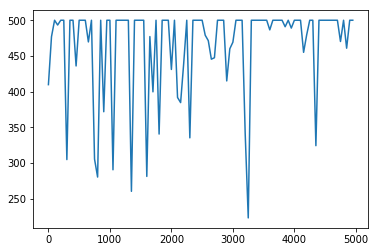

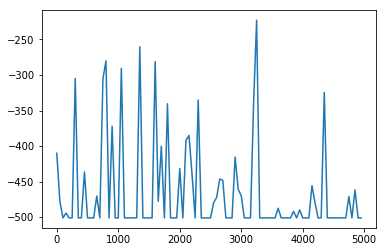

In [18]:
#part b - q learning, acrobot

# Some initialization #
eval_steps, eval_reward, = [], []

#following algorithm from RL book pg 131
env = gym.make('Acrobot-v1')

#discretize - 2 buckets for each (s[0],s[1],s[2],s[3] range from -1 to 1, s[4] ranges from -4pi to 4pi, s[5] ranges from -9pi to 9pi) )
#--> 2^6 = 64 total states 

Q = np.zeros((64,3)) #64 states x 3 actions
g = 0.99
e = 0.95
alpha = 0.000008
actions = [0, 1, 2]

def discretize(s):
    if s[0] < 0:
        s_0 = 0
    else:
        s_0 = 1
    
    if s[1] < 0:
        s_1 = 0
    else:
        s_1 = 1
        
    if s[2] < 0:
        s_2 = 0
    else:
        s_2 = 1
    
    if s[3] < 0:
        s_3 = 0
    else:
        s_3 = 1
        
    if s[4] < 0:
        s_4 = 0
    else:
        s_4 = 1
        
    if s[5] < 0:
        s_5 = 0
    else:
        s_5 = 1
    
    state = (s_0*(2**0))+(s_1*(2**1))+(s_2*(2**2))+(s_3*(2**3))+(s_4*(2**4))+(s_5*(2**5)) #like binary
    return state

        
for i in range(0,5000):#loop for each episode
    s = discretize(env.reset()) #initialize S
    done = 0
    while (done==0):
        if np.random.rand() < e: #perform randomly selected action
            a = np.random.choice(actions)
        else: #perform greedy action
            a = np.argmax(Q[s,:]) #choose action from state using policy derived from Q
        result = env.step(a) #take action a
        s_prime = discretize(result[0])
        r = result[1]
        done = result[2]
        Q[s,a] = Q[s,a] + (alpha*(r + (g*max(Q[s_prime,:])) - Q[s,a])) #update Q* estimate using Bellman
        s = s_prime
    if np.mod(i+1,50) == 0: #every 50 steps evaluate
        avg_step, avg_reward = evaluation_cts(gym.make('Acrobot-v1'), Q)
        eval_steps.append(avg_step)
        eval_reward.append(avg_reward)
        
# Plot example #
np.save('3_Q',Q)
f1, ax1 = plt.subplots()
ax1.plot(np.arange(0,5000,50),eval_steps)#repeat for different algs.
f2, ax2 = plt.subplots()
ax2.plot(np.arange(0,5000,50),eval_reward)#repeat for different algs.

In [1]:
#3. Continuous State Space Problems

#MountainCar-v0

#REINCORCE following algorithm from RL book pg 330
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000
discount = 0.99
alpha = 0.0057
actions = [0, 1, 2]
theta = np.zeros((2,3)) #state vector x num actions

def policy(s,theta): #from https://medium.com/samkirkiles/reinforce-policy-gradients-from-scratch-in-numpy-6a09ae0dfe12
    z = s.dot(theta)
    exp = np.exp(z)
    return exp/np.sum(exp)

def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

for i in range(0,100): #loop more times to get better policy
    done = 0
    s = env.reset()[None,:]
    s[0][1] = s[0][1]*25
    rewards = []
    grads = []
    v = -1 #moving average of total rewards, baseline
    t = 0
    while (not done): #generate an episode
        t = t+1
        probs = policy(s,theta)
        if i >= 95:
            env.render() #see last few iterations of learning
        a = np.random.choice(actions,p=probs[0])
        result = env.step(a)
        next_s = result[0][None,:]
        next_s[0][1] = next_s[0][1]*25
        reward = result[1]
        rewards.append(reward)
        done = result[2]
        
        #compute gradient
        dsoftmax = softmax_grad(probs)[a,:]
        dlog = dsoftmax / probs[0,a]
        grad = s.T.dot(dlog[None,:])
        grads.append(grad)
        
        s = next_s
        
    #print("Episode finished after {} timesteps".format(t))   
    for j in range(0,len(grads)):
        G = 0
        for k in range(j+1,len(grads)):
            G = G + ((discount**(k-j-1))*rewards[k])
        delta = G-v
        v = sum(rewards[0:j])/(j+1)
        theta = theta + (alpha * (discount**j) * delta * grads[j])
    if i >= 95:
        print("Episode finished after {} timesteps".format(t))
        print(theta)
env.close()
np.save('theta_mountaincar',theta)

Episode finished after 196 timesteps
[[ 1.31025725  3.17478947 -4.48504673]
 [-0.53902064 -2.81935138  3.35837202]]
Episode finished after 369 timesteps
[[ 2.07520283  3.2868585  -5.36206133]
 [-0.69651137 -2.75617117  3.45268255]]
Episode finished after 340 timesteps
[[ 1.62651145  3.33046632 -4.95697777]
 [-0.95160641 -2.52768576  3.47929216]]
Episode finished after 266 timesteps
[[ 1.9044813   2.87359297 -4.77807426]
 [-0.45422802 -2.94507785  3.39930587]]
Episode finished after 199 timesteps
[[ 1.90352332  3.20100458 -5.10452791]
 [-0.44378878 -2.45442814  2.89821692]]


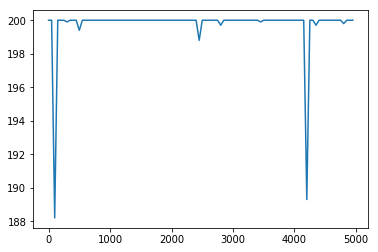

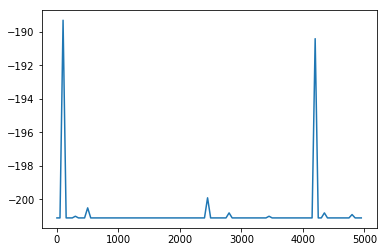

In [20]:
#part b - q learning, mountaincar

# Some initialization #
eval_steps, eval_reward, = [], []

#following algorithm from RL book pg 131
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

#discretize - 2 buckets for each (s[0] ranges from -1.2 to 0.6, s[1] ranges -0.07 to 0.07)
#--> 2^2 = 4 total states 

Q = np.zeros((4,3)) #64 states x 3 actions
g = 0.99
e = 0.95
alpha = 0.01
actions = [0, 1, 2]

def discretize(s):
    if s[0] < -0.3:
        s_0 = 0
    else:
        s_0 = 1
    
    if s[1] < 0:
        s_1 = 0
    else:
        s_1 = 1
        
    state = (s_0*(2**0))+(s_1*(2**1))#like binary
    return state

        
for i in range(0,5000):#loop for each episode
    s = discretize(env.reset()) #initialize S
    done = 0
    while (done==0):
        if np.random.rand() < e: #perform randomly selected action
            a = np.random.choice(actions)
        else: #perform greedy action
            a = np.argmax(Q[s,:]) #choose action from state using policy derived from Q
        result = env.step(a) #take action a
        s_prime = discretize(result[0])
        r = result[1]
        done = result[2]
        Q[s,a] = Q[s,a] + (alpha*(r + (g*max(Q[s_prime,:])) - Q[s,a])) #update Q* estimate using Bellman
        s = s_prime
    if np.mod(i+1,50) == 0: #every 50 steps evaluate
        avg_step, avg_reward = evaluation_cts_mountaincar(gym.make('MountainCar-v0'), Q)
        eval_steps.append(avg_step)
        eval_reward.append(avg_reward)
        
# Plot example #
np.save('3_Q_mountaincar',Q)
f1, ax1 = plt.subplots()
ax1.plot(np.arange(0,5000,50),eval_steps)#repeat for different algs.
f2, ax2 = plt.subplots()
ax2.plot(np.arange(0,5000,50),eval_reward)#repeat for different algs.